In [1]:
import os
import sys
import numpy as np
import nibabel as nib
import pydicom
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import zeros, newaxis
from scipy.stats import norm
import scipy.stats as stats
import cv2
import scipy.signal as signal
from pydicom.pixel_data_handlers.util import apply_color_lut
from skimage.filters import threshold_multiotsu
from skimage.filters import threshold_otsu, threshold_local
import SimpleITK as sitk
from scipy import spatial
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import skimage

from sklearn.linear_model import LinearRegression
import scipy.optimize

# Util functions

In [2]:
def monoExp(x, C, t2, A):
    return C * np.exp(-x/t2) + A
def monoExp2(x,params):  
#     C=15.028
    C=params[0]
    t2=params[1]
    A=params[2]
#     A=1
#     C=C
#     A=0
    return C * np.exp(-x/t2) + A

In [3]:
def read_data(path):
    nii=nib.load(path)
    data=np.asanyarray(nii.dataobj)
    
    return nii, data
        
def save_nii(data, nii, path2save):
    nii2save=nib.Nifti1Image(data, nii.affine)
    nib.save(nii2save, path2save)
    
def get_baseline_vals(img_s, seg, segmentationArr, data):
    """
    img_s: image slice to be analysed
    seg: segmentation id of baseline
    segmentationArr: segmentation np array
    data: mri raw np array
    
    returns;
    baseline: pixel values for baseline area nparray (len(vals), len(echos))
    """
    segmentation=segmentationArr[:,:,img_s]
    num_echos=data.shape[-1]
    
    for echo in range(num_echos):
        img=data[:,:,img_s,echo]
        vals=img[segmentation==seg]

        if echo==0:
            baseline=np.zeros((len(vals),8))
            baseline[:,0]=vals
        else:
            baseline[:,echo]=vals
            
    return baseline

def img_zscore(img,baseline,echo):
    """
    Returns z-score based on baseline mean and std
    """
    return (img-np.mean(baseline[:,echo]))/np.std(baseline[:,echo])

def read_labels(labels_path):
    """
    Reading SimpleITK-Snap generated labels
    """
    labels=[]
    anats=[]
    with open(labels_path) as f:
        lines = f.readlines()
        for i,line in enumerate(lines):
            if i>14:
                if i==7:
                    anat= ' '.join(line.split('\\cf')[1].split()[8:])
                    anats.append(anat.split("\"")[1])
                    labels.append(int(line.split('\\cf')[1].split()[0]))
                else:
                    anat=' '.join(line.split()[7:])
                    anats.append(anat.split("\"")[1])
                    labels.append(int(line.split()[0]))

    df=pd.DataFrame()
    df["Labels"]=labels
    df["Anatomical Regions"]=anats
    return df

def get_neigh_basestruct(idx, basestruct, labelsdf, segmentation_mask):
    """
    idx: index to be checked which baseline is nearest to
    basestruct: list of struct names as possible baselines
    labelsdf: df including the segmentation names and values
    segmentation_mask: corresponding segmentation img slice
    """
    dist=[]
    neighidx=[]
    for base in basestruct:
        base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"]==base].values[0]
        baseidx=np.array(list(zip(*np.where(segmentation_mask==base_seg))))
        normarr=np.linalg.norm(baseidx-idx, axis=1)
        closestidx=np.argmin(normarr)

        dist.append(normarr[closestidx])
        neighidx.append(baseidx[closestidx])
        
    struct=basestruct[np.argmin(dist)]
    base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"]==struct].values[0]
    return base_seg, struct, neighidx, dist

def weighted_pixel_index(img, index, xind_w, xind_coef, yind_w, yind_coef):
    xind_w.append(index[1]*((255-img[index[0],index[1]])/255))
    xind_coef.append((255-img[index[0],index[1]])/255)
                
    yind_w.append(index[0]*((255-img[index[0],index[1]])/255))
    yind_coef.append((255-img[index[0],index[1]])/255)
    
    return xind_w, xind_coef, yind_w, yind_coef

def minima_pixel(img, index, minimaTmp, minimIdx):
    if minimaTmp>img[index[0],index[1]]:
        minimaTmp=img[index[0],index[1]]
        minimIdx=index
    return minimaTmp, minimIdx

In [4]:
def single_baseline(elecSeg, img_slice, baseStruct, root, analysedPath, labelsdf):
#     struct="crtx"
    print("Baseline structure: "+baseStruct)
    base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"]==baseStruct].values[0]
    baseline=get_baseline_vals(img_slice, base_seg, coronal1seg, coronal1data)        
    segmentation_mask=coronal1seg[:,:,img_slice]

#     segname="mono"
    elec_segs=labelsdf["Labels"][labelsdf["Anatomical Regions"]==elecSeg].values
    print("Segment of interest: "+elecSeg)
    save_path=root+analysedPath+elecSeg+"-"+baseStruct+"_base/"
    dpi=1000
    savefigs=True
    zthr=-1.95

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    num_echos=coronal1data.shape[-1]
    mean_intensities=np.zeros([len(elec_segs),num_echos])

    px_count=np.zeros((len(elec_segs),num_echos))
    px_intensities=[]

    for j,seg in enumerate(elec_segs):
        tmpvals=[]
        for echo in range(num_echos):
            img=coronal1data[:,:,img_slice,echo]
            imgz=img_zscore(img,baseline,echo)
    #         imgz=(img-np.mean(baseline[:,echo]))/np.std(baseline[:,echo])

            imgz=imgz*(segmentation_mask==seg)
            vals_z=imgz[segmentation_mask==seg]
            ind=np.where(imgz<zthr)
            px_count[j, echo]=np.sum(vals_z<zthr)
            vals=img[ind]
            tmpvals.append(vals)
            mean_intensities[j,echo]=np.mean(vals)

            plt.imshow(img, cmap='gray')
            plt.scatter(ind[1],ind[0], c='r', s=0.01)
            if savefigs:
                filename=elecSeg+str(seg)+"echo"+str(echo)+".png"
                plt.savefig(save_path+filename, dpi=dpi)
            plt.show()

        px_intensities.append(tmpvals)

In [5]:
def get_length(ind):
    indx, indy = ind
    allIdx=np.concatenate((np.reshape(indx,(-1,1)),np.reshape(indy,(-1,1))),axis=1)
    candidates = allIdx[spatial.ConvexHull(allIdx).vertices]
    # get distances between each pair of candidate points
    dist_mat = spatial.distance_matrix(candidates, candidates)

    # get indices of candidates that are furthest apart
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)

#     plt.scatter(allIdx[:,1],allIdx[:,0])
#     plt.scatter(candidates[:,1],candidates[:,0], linewidths=1)
#     plt.scatter(candidates[i][1],candidates[i][0])
#     plt.scatter(candidates[j][1],candidates[j][0])

    p1=candidates[i][:]
    p2=candidates[j][:]
    length=np.linalg.norm((p1-p2))
    return p1, p2, length      

In [6]:
def get_endpoints(segments, centers, masks, save_path, save_fig=True):
# segments=seg_areas
# centers=weightedCenters
# echo=0
#     seg_img=masks
    closePoints=np.empty((len(segments),2))
    farPoints=np.empty((len(segments),2))

    for i, seg in enumerate(segments):
        if masks[i, echo, :, :].any():
            center1=centers[i,echo,:]

            if i==0:
                center2=centers[i+1,echo,:]
                u21=(center2-center1)/np.linalg.norm(center2-center1)
                u12=u21
            elif i==len(segments)-1:
                center3=centers[i-1,echo,:]
                u12=(center1-center3)/np.linalg.norm(center3-center1)
                u21=u12
            else:
                center2=centers[i+1,echo,:]
                center3=centers[i-1,echo,:]
                u21=(center2-center1)/np.linalg.norm(center2-center1)
                u12=(center1-center3)/np.linalg.norm(center3-center1)

            alpha=1
            while True: 
                closeP=np.round(center1+alpha*u21)
                y,x=closeP.astype(int)
                if masks[i, echo, x, y]==1:
                    alpha=alpha+1
                else:
                    closeP=closeP-u21
                    break
            alpha=1
            while True: 
                farP=np.round(center1-alpha*u12)
                y,x=farP.astype(int)
                if masks[i, echo, x, y]==1:
                    alpha=alpha+1
                else:
                    farP=farP+u12
                    break

            closePoints[i,:]=closeP
            farPoints[i,:]=farP

        else:
            closePoints[i,:]=center1
            farPoints[i,:]=center1
    plt.figure()
    plt.imshow(coronal2[:,:,img_slice,echo], cmap='gray')
    plt.scatter(np.round(weightedCenters[:,echo,0]),np.round(weightedCenters[:,echo,1]), c='r', s=0.1)
    plt.scatter(closePoints[:,0], closePoints[:,1],marker="*", c='b', s=0.01)
    plt.scatter(farPoints[:,0], farPoints[:,1],marker="*", c='m', s=0.01)
    if save_fig:
        filename="endpoints-echo"+str(echo)+".png"
        plt.savefig(save_path+filename, dpi=dpi)
        
    return farPoints, closePoints

In [ ]:
def plot_centers(data, num_echos, minimaCenters=[], pxAvgCenters=[], weightedPxCenters=[], save_path=""):
    dpi=1000
    for echo in range(num_echos):
        if minimaCenters.any():
            plt.figure()
            plt.imshow(data[:,:,echo], cmap='gray')
            plt.scatter(minimaCenters[:,echo,1],minimaCenters[:,echo,0], c='r', s=0.01)
            filename="tri-echo"+str(echo)+"-minimas.png"
            plt.savefig(save_path+filename, dpi=dpi)
            plt.show()
        if pxAvgCenters.any():
            plt.figure()
            plt.imshow(data[:,:,echo], cmap='gray')
            plt.scatter(np.round(pxAvgCenters[:,echo,0]),np.round(pxAvgCenters[:,echo,1]), c='r', s=0.01)
            filename="tri-echo"+str(echo)+"-avgCenters.png"
            plt.savefig(save_path+filename, dpi=dpi)
            plt.show()
        if weightedPxCenters.any():
            plt.figure()
            plt.imshow(data[:,:,echo], cmap='gray')
            plt.scatter(np.round(weightedPxCenters[:,echo,0]),np.round(weightedPxCenters[:,echo,1]), c='r', s=0.01)
            filename="tri-echo"+str(echo)+"-weightedCenters.png"
            plt.savefig(save_path+filename, dpi=dpi)
            plt.show()

In [7]:
def monoExp(x, C, t2, A):
    return C * np.exp(-x/t2) + A
def monoExp2(x,params):  
#     C=15.028
    C=params[0]
    t2=params[1]
    A=params[2]
#     A=1
#     C=C
#     A=0
    return C * np.exp(-x/t2) + A


def relaxation(data, elecSegment, baseline, masks, echos=np.linspace(5,40,8), savepath=""):
    pxIntMeans=np.empty((len(echos),))
    pxIntstd=np.empty((len(echos),))
    for echo in range(len(echos)-1):
        img=data[:,:,echo]
        pxIntMeans[echo]=np.mean(img[masks[elecSegment,-1,:,:]==1])
        pxIntstd[echo]=np.std(img[masks[elecSegment,-1,:,:]==1])
#         pxIntMeans[echo]=np.mean(img[masks[elecSegment,echo+1,:,:]==1])
#         pxIntstd[echo]=np.std(img[masks[elecSegment,echo+1,:,:]==1])
    
    img=data[:,:,-1]
    pxIntMeans[-1]=np.mean(img[masks[elecSegment,-1,:,:]==1])
    pxIntstd[-1]=np.std(img[masks[elecSegment,-1,:,:]==1])
    
    p0=(50, 30,0)
    paramsBase, cvBase = scipy.optimize.curve_fit(monoExp, echos, np.mean(baseline,axis=0), p0, np.std(baseline,axis=0), bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,np.inf]))
    Cbase,t2Base,Abase = paramsBase
    
    if Abase>np.std(baseline,axis=0)[-1]:
        Alower=Abase-np.std(baseline,axis=0)[-1]
    else:
        Alower=0
    Aupper=Abase+np.std(baseline,axis=0)[-1]
    
    paramsData, cvData = scipy.optimize.curve_fit(monoExp, echos, pxIntMeans, paramsBase, pxIntstd, bounds=([Cbase-np.std(baseline,axis=0)[0], -np.inf, Alower], [Cbase+np.std(baseline,axis=0)[0],np.inf,Aupper]))
    Celec,t2elec,Aelec = paramsData
    
    plt.figure()
    plt.errorbar(echos, pxIntMeans, yerr=pxIntstd, fmt='o', color="blue")
    plt.plot(np.linspace(0,40,9), monoExp(np.linspace(0,40,9), Celec, t2elec, Aelec), color="blue", linewidth=3)
    
    plt.errorbar(echos, np.mean(baseline,axis=0), yerr=np.std(baseline,axis=0), fmt='o', color="red")
    plt.plot(np.linspace(0,40,9), monoExp(np.linspace(0,40,9), Cbase, t2Base, Abase), color="red", linewidth=3)
    
    
    plt.ylabel("Signal a.u.")
    plt.xlabel("Time (ms)")
    plt.legend(["Electrode echo",  "Electrode Decay"])
    if savepath:
        plt.savefig(savepath+"elec"+str(elecSegment)+"_relaxation.pdf")
    plt.show()
    
    return paramsBase, paramsData


def relaxation_fixedROI(data, center,  elecSegment, baseline, r=3, echos=np.linspace(5,40,8), savepath=""):

    disk=skimage.morphology.disk(r)
    x,y=center
    pxIntMeans=np.empty((len(echos),))
    pxIntstd=np.empty((len(echos),))
    
    for echo in range(len(echos)):
        img=data[:,:,echo]
        mask=np.zeros((256,256))
        mask[x-r:x+r+1, y-r:y+r+1]=disk
        
        pxIntMeans[echo]=np.mean(img[mask==1])
        pxIntstd[echo]=np.std(img[mask==1])
        
    p0=(50, 30,0)
    paramsBase, cvBase = scipy.optimize.curve_fit(monoExp, echos, np.mean(baseline,axis=0), p0, np.std(baseline,axis=0), bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,np.inf]))
    Cbase,t2Base,Abase = paramsBase
    p_sigma_base = np.sqrt(np.diag(cvBase))

    
    if Abase>np.std(baseline,axis=0)[-1]:
        Alower=Abase-np.std(baseline,axis=0)[-1]
    else:
        Alower=0
    Aupper=Abase+np.std(baseline,axis=0)[-1]
    
    paramsData, cvData = scipy.optimize.curve_fit(monoExp, echos, pxIntMeans, paramsBase, pxIntstd, bounds=([Cbase-np.std(baseline,axis=0)[0], -np.inf, Alower], [Cbase+np.std(baseline,axis=0)[0],np.inf,Aupper]))
    Celec,t2elec,Aelec = paramsData
    p_sigma_data = np.sqrt(np.diag(cvData))
    
    plt.figure()
    plt.errorbar(echos, pxIntMeans, yerr=pxIntstd, fmt='o', color="blue")
    plt.plot(np.linspace(0,40,9), monoExp(np.linspace(0,40,9), Celec, t2elec, Aelec), color="blue", linewidth=3)
    
    plt.errorbar(echos, np.mean(baseline,axis=0), yerr=np.std(baseline,axis=0), fmt='o', color="red")
    plt.plot(np.linspace(0,40,9), monoExp(np.linspace(0,40,9), Cbase, t2Base, Abase), color="red", linewidth=3)
    
    
    plt.ylabel("Signal a.u.")
    plt.xlabel("Time (ms)")
    plt.legend(["Electrode echo",  "Electrode Decay"])
    if savepath:
        plt.savefig(savepath+"fixedROI-r:"+str(r)+"_elec"+str(elecSegment)+"_relaxation.pdf")
    plt.show()
    
    return paramsBase, paramsData, p_sigma_base, p_sigma_data

# rEO_08

In [8]:
root="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/RAT DATA/rEO_08/"
bids="mri-raw/bids/sub-rEO_08/ses-postsurgery20240502/anat/"
analysed="mri-analysed/"

## Mono, coronal:1, slice:3, 

In [638]:
coronal1filename="sub-rEO_08_ses-postsurgery20240502_task-coronal_acq-T2starMapMGE_T2w-ind_9.nii.gz"
coronal1segfilename="rEO_08-coronal-t2sMGE-segmentation.nii.gz"
labelspath="rEO_08-coronal-t2sMGE-labels.txt"
_, coronal1data=read_data(root+bids+coronal1filename)
_, coronal1seg=read_data(root+bids+coronal1segfilename)
labelsdf=read_labels(root+bids+labelspath)

Segment of interest: mono sitk-label:0    1
Name: Labels, dtype: int64


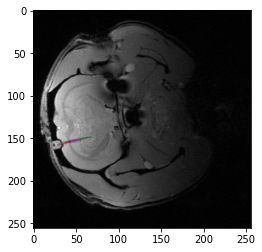

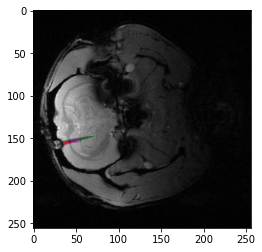

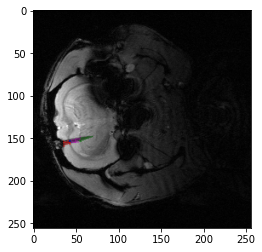

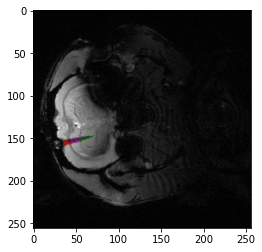

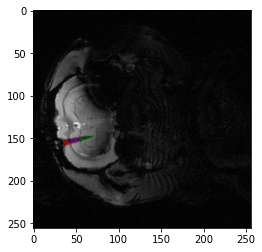

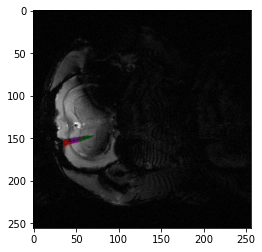

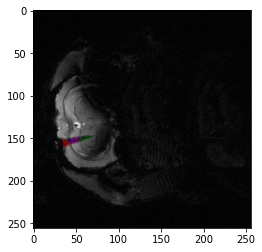

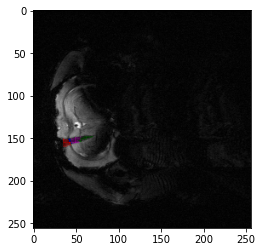

In [644]:
basestruct=["crtx","cc","hpc", "thlms"]
segname="mono"
img_slice=2
segmentation_mask=coronal1seg[:,:,img_slice]
# seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"]==segname].values
seg_areas=labelsdf["Labels"][df["Anatomical Regions"].str.contains(segname)]
print("Segment of interest: "+segname+" sitk-label:"+str(seg_areas))
save_path=root+analysed+segname+"-regionspecific/"
dpi=1000
savefigs=False
zthr=-1.95

if not os.path.exists(save_path):
    os.mkdir(save_path)

num_echos=coronal1data.shape[-1]
mean_intensities=np.zeros([len(seg_areas),num_echos])

px_count=np.zeros((len(seg_areas),num_echos))
px_intensities=[]
ind=[]


for j,seg in enumerate(seg_areas):
    tmpvals=[]
    for echo in range(num_echos):
        echovals=[]
        crtxidx=[]
        hpcidx=[]
        thlmsidx=[]
        ccidx=[]
        indx=[]
        indy=[]
        pxcnt=0
        img=coronal1data[:,:,img_slice,echo]
        for index in np.array(list(zip(*np.where(segmentation_mask==seg)))):
            base_seg,struct,_,_=get_neigh_basestruct(index, basestruct, labelsdf, segmentation_mask)
            baseline=get_baseline_vals(img_slice, base_seg, coronal1seg, coronal1data)        
            imgz=img_zscore(img[index[0],index[1]],baseline,echo)
            
            if imgz<zthr:
                indx.append(index[0])
                indy.append(index[1])
                
                if struct=="crtx":
                    crtxidx.append(index)
                elif struct =="cc":
                    ccidx.append(index)
                elif struct=="hpc":
                    hpcidx.append(index)
                elif struct=="thlms":
                    thlmsidx.append(index)
                    
                pxcnt=pxcnt+1
                echovals.append(img[index[0],index[1]])
        
        crtxidx=np.array(crtxidx)
        ccidx=np.array(ccidx)
        hpcidx=np.array(hpcidx)
        thlmsidx=np.array(thlmsidx)

        px_count[j, echo]=pxcnt
        mean_intensities[j,echo]=np.mean(echovals)
        tmpvals.append(echovals)
        
        plt.imshow(img, cmap='gray')
        plt.scatter(crtxidx[:,1], crtxidx[:,0], c='r', s=0.01)
        plt.scatter(ccidx[:,1], ccidx[:,0], c='b', s=0.01)
        plt.scatter(hpcidx[:,1], hpcidx[:,0], c='m', s=0.01)
        plt.scatter(thlmsidx[:,1], thlmsidx[:,0], c='g', s=0.01)
#         plt.scatter(indy, indx, c='r', s=0.01)
        if savefigs:
            filename=segname+str(seg)+"echo"+str(echo)+".png"
            plt.savefig(save_path+filename, dpi=dpi)
        plt.show()
        
    px_intensities.append(tmpvals)

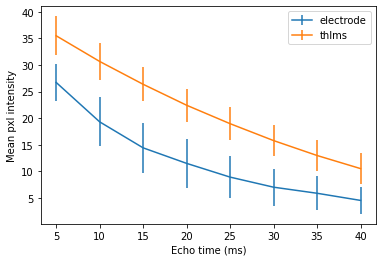

In [703]:
struct="thlms"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"]==struct].values[0]
baseline=get_baseline_vals(img_slice, base_seg, coronal1seg, coronal1data)        

means=[]
s=[]
x=np.linspace(5,40,8)

for i in px_intensities[0]:
    means.append(np.mean(i))
    s.append(np.std(i))
    
# plt.plot(means)
plt.figure()
plt.errorbar(x,means,yerr=s)
plt.errorbar(x, np.mean(baseline, axis=0), yerr=np.std(baseline, axis=0))
plt.xlabel("Echo time (ms)")
plt.ylabel("Mean pxl intensity")
plt.legend(["electrode", struct])
filename="meanIntensity-echo-vs_"+struct+".pdf"
plt.savefig(save_path+filename, dpi=1000)

Segment of interest: mono sitk-label:[1]


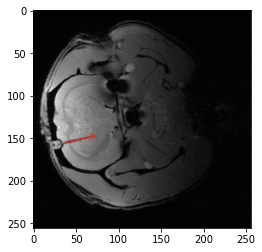

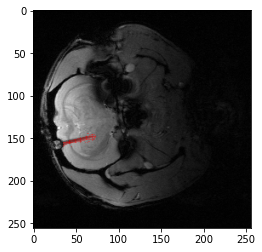

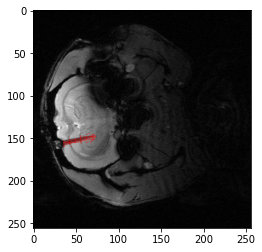

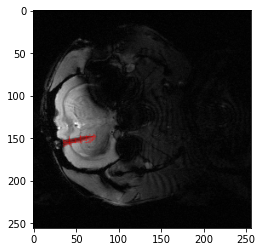

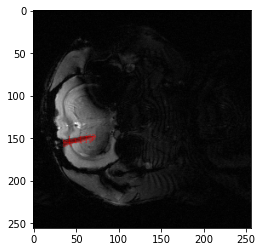

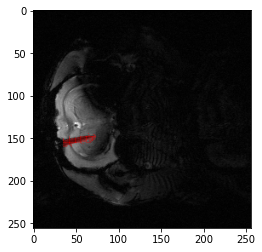

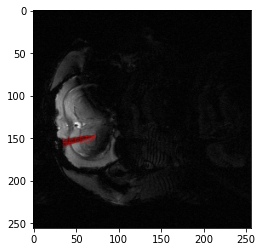

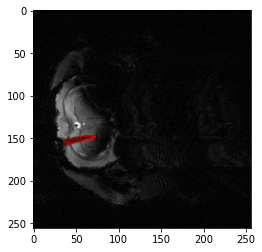

In [620]:
struct="crtx"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"]==struct].values[0]
baseline=get_baseline_vals(img_slice, base_seg, coronal1seg, coronal1data)        
segmentation_mask=coronal1seg[:,:,img_slice]

segname="mono"
seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"]==segname].values
print("Segment of interest: "+segname+" sitk-label:"+str(seg_areas))
save_path=root+analysed+segname+"-"+struct+"base/"
dpi=1000
savefigs=True
zthr=-1.95

if not os.path.exists(save_path):
    os.mkdir(save_path)

num_echos=coronal1data.shape[-1]
mean_intensities=np.zeros([len(segments),num_echos])

px_count=np.zeros((len(seg_areas),num_echos))
px_intensities=[]

for j,seg in enumerate(seg_areas):
    tmpvals=[]
    for echo in range(num_echos):
        img=coronal1data[:,:,img_slice,echo]
        imgz=img_zscore(img,baseline,echo)
#         imgz=(img-np.mean(baseline[:,echo]))/np.std(baseline[:,echo])

        imgz=imgz*(segmentation_mask==seg)
        vals_z=imgz[segmentation_mask==seg]
        ind=np.where(imgz<zthr)
        px_count[j, echo]=np.sum(vals_z<zthr)
        vals=img[ind]
        tmpvals.append(vals)
        mean_intensities[j,echo]=np.mean(vals)

        plt.imshow(img, cmap='gray')
        plt.scatter(ind[1],ind[0], c='r', s=0.01)
        if savefigs:
            filename=segname+str(seg)+"echo"+str(echo)+".png"
            plt.savefig(save_path+filename, dpi=dpi)
        plt.show()
        
    px_intensities.append(tmpvals)

## Duo-pattern

Segment of interest: duo sitk-label:5    6
6    7
Name: Labels, dtype: int64


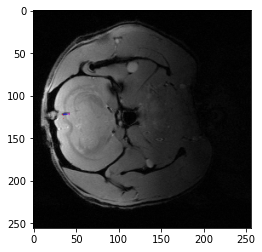

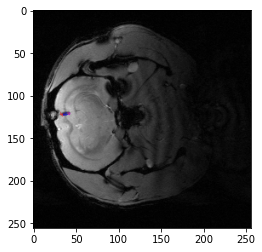

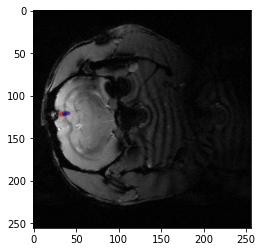

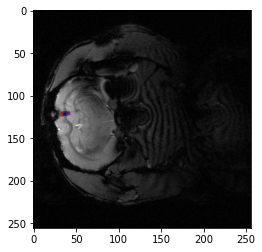

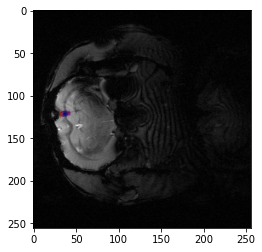

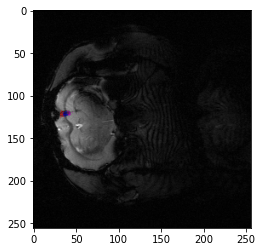

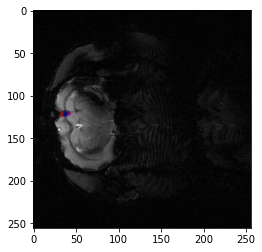

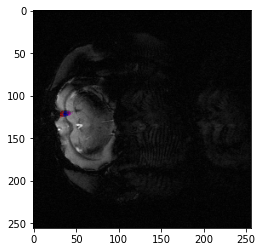

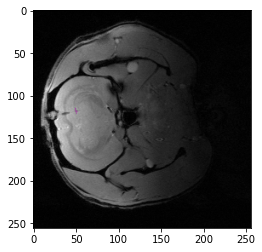

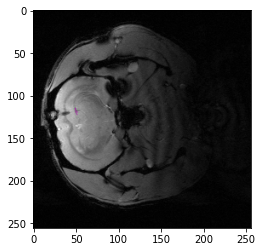

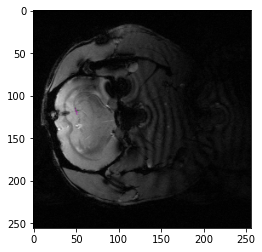

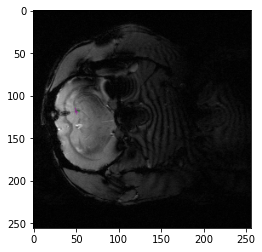

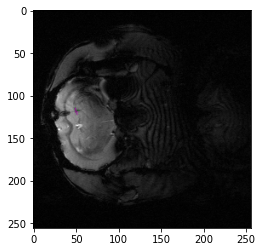

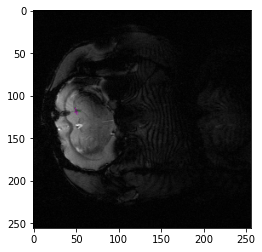

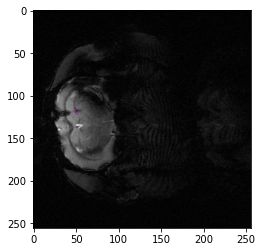

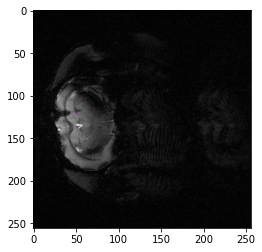

In [641]:
basestruct=["crtx","cc","hpc", "thlms"]
segname="duo"
img_slice=3
segmentation_mask=coronal1seg[:,:,img_slice]

# seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"]==segname].values
seg_areas=labelsdf["Labels"][df["Anatomical Regions"].str.contains(segname)]
print("Segment of interest: "+segname+" sitk-label:"+str(seg_areas))
save_path=root+analysed+segname+"-regionspecific/"
dpi=1000
savefigs=True
zthr=-1.95

if not os.path.exists(save_path):
    os.mkdir(save_path)

num_echos=coronal1data.shape[-1]
mean_intensities=np.zeros([len(segments),num_echos])

px_count=np.zeros((len(seg_areas),num_echos))
px_intensities=[]
ind=[]


for j,seg in enumerate(seg_areas):
    tmpvals=[]
    for echo in range(num_echos):
        echovals=[]
        crtxidx=[]
        hpcidx=[]
        thlmsidx=[]
        ccidx=[]
        indx=[]
        indy=[]
        pxcnt=0
        img=coronal1data[:,:,img_slice,echo]
        for index in np.array(list(zip(*np.where(segmentation_mask==seg)))):
            base_seg,struct,_,_=get_neigh_basestruct(index, basestruct, labelsdf, segmentation_mask)
            baseline=get_baseline_vals(img_slice, base_seg, coronal1seg, coronal1data)        
            imgz=img_zscore(img[index[0],index[1]],baseline,echo)
            
            if imgz<zthr:
                indx.append(index[0])
                indy.append(index[1])
                if struct=="crtx":
                    crtxidx.append(index)
                elif struct =="cc":
                    ccidx.append(index)
                elif struct=="hpc":
                    hpcidx.append(index)
                elif struct=="thlms":
                    thlmsidx.append(index)
                pxcnt=pxcnt+1
                
            echovals.append(imgz)
        
        crtxidx=np.array(crtxidx)
        ccidx=np.array(ccidx)
        hpcidx=np.array(hpcidx)
        thlmsidx=np.array(thlmsidx)

        px_count[j, echo]=pxcnt
        mean_intensities[j,echo]=np.mean(echovals)
        tmpvals.append(echovals)
        plt.imshow(img, cmap='gray')
        if crtxidx.any():
            plt.scatter(crtxidx[:,1], crtxidx[:,0], c='r', s=0.01)
        if ccidx.any():
            plt.scatter(ccidx[:,1], ccidx[:,0], c='b', s=0.01)
        if hpcidx.any():
            plt.scatter(hpcidx[:,1], hpcidx[:,0], c='m', s=0.01)
        if thlmsidx.any():
            plt.scatter(thlmsidx[:,1], thlmsidx[:,0], c='g', s=0.01)
#         plt.scatter(indy, indx, c='r', s=0.01)
        if savefigs:
            filename=segname+str(seg)+"echo"+str(echo)+".png"
            plt.savefig(save_path+filename, dpi=dpi)
        plt.show()
        
    px_intensities.append(tmpvals)

## rEO_08 coronal2_slice:3, quad-zone pattern

In [9]:
path="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/RAT DATA/rEO_08/mri-raw/bids/sub-rEO_08/ses-postsurgery20240502/anat/sub-rEO_08_ses-postsurgery20240502_task-coronal2_acq-T2starMapMGE_T2w-ind_10.nii.gz"
pathseg="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/RAT DATA/rEO_08/mri-raw/bids/sub-rEO_08/ses-postsurgery20240502/anat/rEO_08-coronal2-t2sMGE-segmentation.nii.gz"

_, coronal2=read_data(path)
_, coronal2seg=read_data(pathseg)
labelspath="rEO_08-coronal2-t2sMGE-labels.txt"
labelsdf=read_labels(root+bids+labelspath)

Segment of interest: quad sitk-label:3    4
4    5
5    6
6    7
Name: Labels, dtype: int64


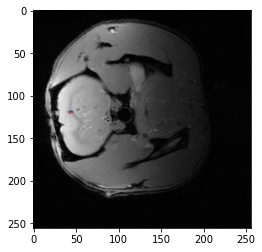

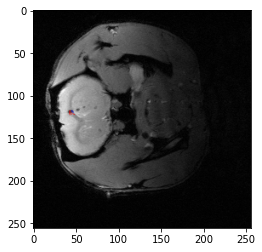

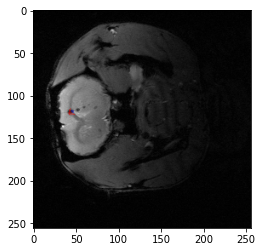

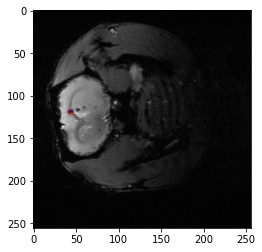

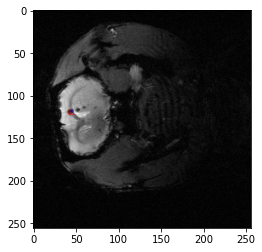

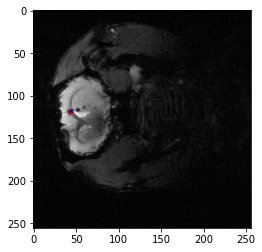

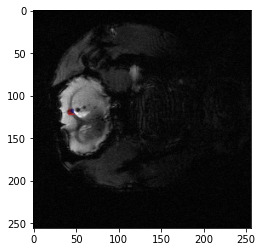

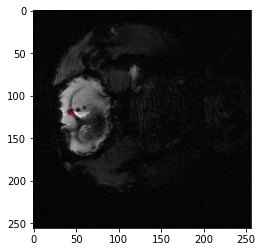

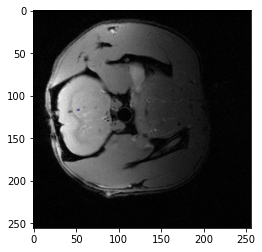

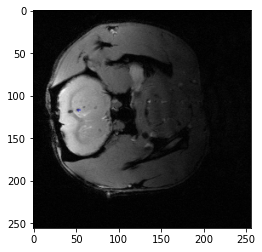

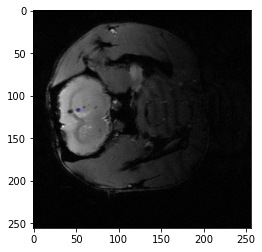

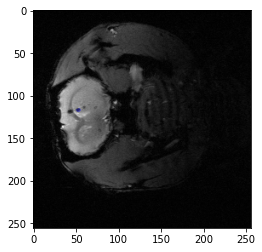

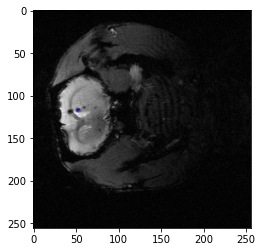

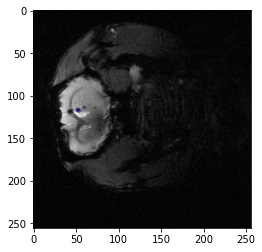

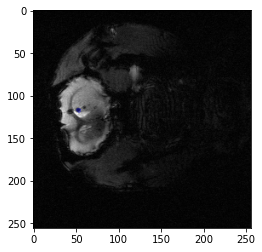

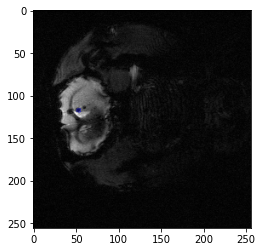

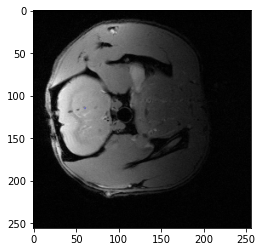

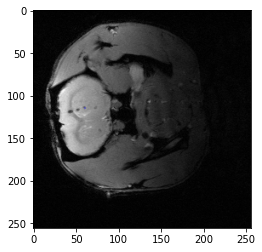

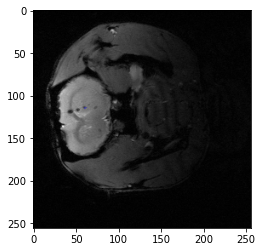

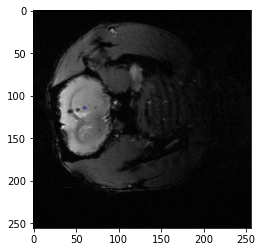

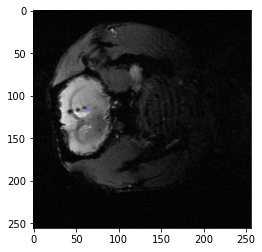

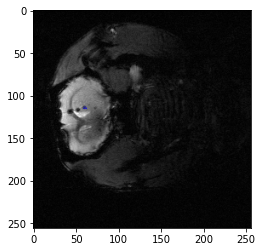

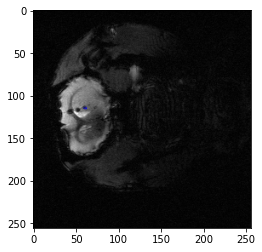

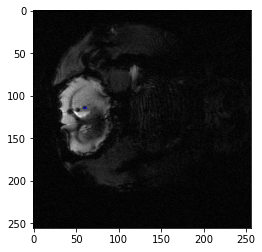

/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


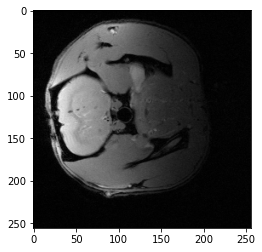

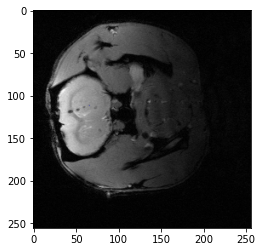

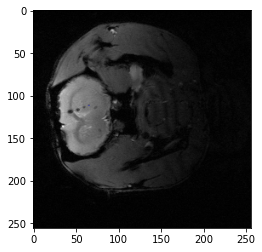

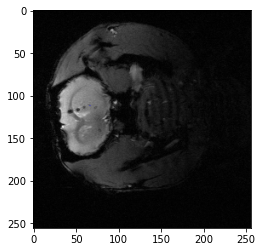

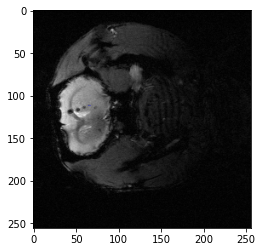

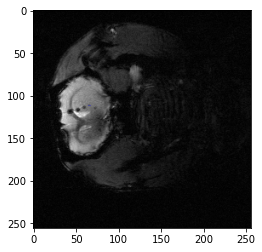

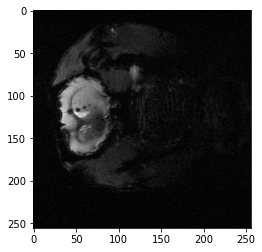

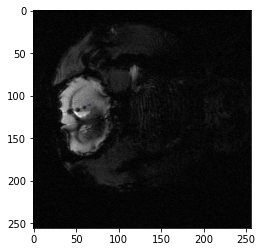

In [29]:
# PDF for baseline
# img_s=3 #3rd coronal slice
# seg=10 #Triathum, below the CC

# baseline=get_baseline_vals(img_s, seg, coronal2seg, coronal2)   

basestruct=["crtx","deepTissue"]
segname="quad"
img_slice=3
segmentation_mask=coronal2seg[:,:,img_slice]

# seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"]==segname].values
seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(segname)]
print("Segment of interest: "+segname+" sitk-label:"+str(seg_areas))
save_path=root+analysed+segname+"-regionspecific/"
dpi=1000
savefigs=False
zthr=-1.95

if not os.path.exists(save_path):
    os.mkdir(save_path)

num_echos=coronal2.shape[-1]
mean_intensities=np.zeros([len(seg_areas),num_echos])

px_count=np.zeros((len(seg_areas),num_echos))
px_intensities=[]
ind=[]

minimas=np.empty((len(seg_areas), num_echos, 2))
avgCenters=np.empty((len(seg_areas), num_echos, 2))
weightedCenters=np.empty((len(seg_areas), num_echos, 2))

segPxIntensities=[]
masks=np.zeros((len(seg_areas), num_echos, segmentation_mask.shape[0],segmentation_mask.shape[1]))

for j,seg in enumerate(seg_areas):
    tmpvals=[]
    segEchoVals=[]
    
    for echo in range(num_echos):
        echovals=[]
        crtxidx=[]
        hpcidx=[]
        thlmsidx=[]
        ccidx=[]
        indx=[]
        xind_w=[]
        xind_coef=[]
        yind_w=[]
        yind_coef=[]
        indy=[]
        pxcnt=0
        img=coronal2[:,:,img_slice,echo]
        
        
        minimaTmp=999
        minimIdx=[0,0]
        
        segEchoVals.append(img[segmentation_mask==seg])
        for index in np.array(list(zip(*np.where(segmentation_mask==seg)))):
            base_seg,struct,_,_=get_neigh_basestruct(index, basestruct, labelsdf, segmentation_mask)
            baseline=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)        
            imgz=img_zscore(img[index[0],index[1]],baseline,echo)
            minimaTmp, minimIdx = minima_pixel(img, index, minimaTmp, minimIdx)

            if imgz<zthr:
                indx.append(index[1])
                indy.append(index[0])
                xind_w, xind_coef, yind_w, yind_coef= weighted_pixel_index(img, index, xind_w, xind_coef, yind_w, yind_coef)

                if struct==basestruct[0]:
                    crtxidx.append(index)
                elif struct ==basestruct[1]:
                    ccidx.append(index)
                elif struct==basestruct[2]:
                    hpcidx.append(index)
#                 elif struct==basestruct[3]:
#                     thlmsidx.append(index)
                pxcnt=pxcnt+1
                echovals.append(img[index[0],index[1]])
                masks[j,echo,index[0],index[1]]=1
        
        avgCenters[j,echo,0]=np.mean(indx)
        avgCenters[j,echo,1]=np.mean(indy)
        
        weightedCenters[j,echo,0]=np.sum(xind_w)/np.sum(xind_coef)
        weightedCenters[j,echo,1]=np.sum(yind_w)/np.sum(yind_coef)
        
#         p1,p2,length=get_length([indx, indy])
        minimas[j,echo,:]=minimIdx
        crtxidx=np.array(crtxidx)
        ccidx=np.array(ccidx)
        hpcidx=np.array(hpcidx)
        thlmsidx=np.array(thlmsidx)

        px_count[j, echo]=pxcnt
        mean_intensities[j,echo]=np.mean(echovals)
        tmpvals.append(echovals)
        plt.imshow(img, cmap='gray')
        if crtxidx.any():
            plt.scatter(crtxidx[:,1], crtxidx[:,0], c='r', s=0.01)
        if ccidx.any():
            plt.scatter(ccidx[:,1], ccidx[:,0], c='b', s=0.01)
        if hpcidx.any():
            plt.scatter(hpcidx[:,1], hpcidx[:,0], c='m', s=0.01)
        if thlmsidx.any():
            plt.scatter(thlmsidx[:,1], thlmsidx[:,0], c='g', s=0.01)
#         plt.scatter(p1[0], p1[1],marker="*", c='w', s=0.01)
#         plt.scatter(p2[0], p2[1],marker="*", c='w', s=0.01)
        if savefigs:
            filename=segname+str(j)+"echo"+str(echo)+".png"
            plt.savefig(save_path+filename, dpi=dpi)
        plt.show()
        
    segPxIntensities.append(segEchoVals)    
    px_intensities.append(tmpvals)

In [30]:
# img_slice=3
# t2diff=[]

# paramsBase, paramsData=relaxation(coronal2[:,:,img_slice,:], 0, base_cc, masks, savepath=save_path)
# print("Pattern 0")
# print("t2star tissue: "+str(1000/paramsBase[1]))
# print("t2star electrode: "+str(1000/paramsData[1]))
# print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
# t2diff.append(1000/paramsData[1]-1000/paramsBase[1])
# print(paramsBase)
# print(paramsData)

# paramsBase, paramsData=relaxation(coronal2[:,:,img_slice,:], 1, base_deep, masks, savepath=save_path)
# print("Pattern 2")
# print("t2star tissue: "+str(1000/paramsBase[1]))
# print("t2star electrode: "+str(1000/paramsData[1]))
# print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
# t2diff.append(1000/paramsData[1]-1000/paramsBase[1])


# paramsBase, paramsData=relaxation(coronal2[:,:,img_slice,:], 2, base_deep, masks, savepath=save_path)
# print("Pattern 3")
# print("t2star tissue: "+str(1000/paramsBase[1]))
# print("t2star electrode: "+str(1000/paramsData[1]))
# print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
# t2diff.append(1000/paramsData[1]-1000/paramsBase[1])


# plt.figure()
# plt.plot(quad_den[:-1], t2diff)

In [31]:
segment_areas=np.flip([175,1075,2170,7118])
segment_lengths=np.array([670, 300, 295, 295])
segment_densities=segment_areas/segment_lengths
print(segment_densities)

[10.6238806   7.23333333  3.6440678   0.59322034]


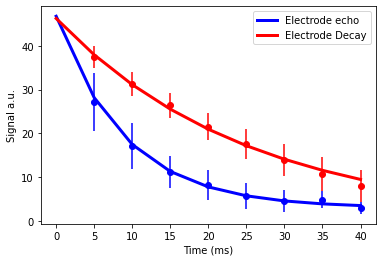

Pattern 0
t2star tissue: 39.58071223719814
t2star electrode: 110.72660388810674
difference: 71.1458916509086


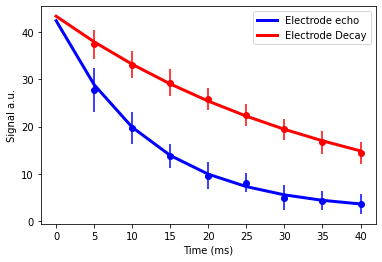

Pattern 1
t2star tissue: 26.70065993616255
t2star electrode: 82.02368626580187
difference: 55.32302632963932


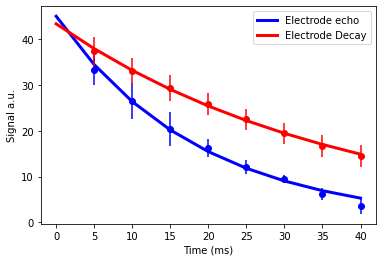

Pattern 2
t2star tissue: 26.70065993616255
t2star electrode: 53.465007769196696
difference: 26.764347833034147


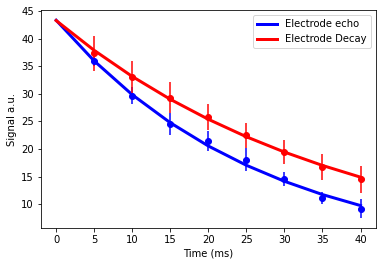

Pattern 3
t2star tissue: 26.70065993616255
t2star electrode: 37.3646842023666
difference: 10.664024266204049


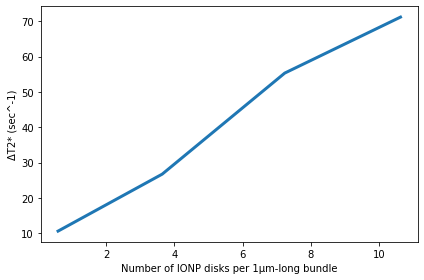

In [33]:
baseName="CC"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_cc=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="crtx"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_crtx=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="deepTissue"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_deep=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)  

# quad_areas=np.flip([175,1075,2170,7118])
# quad_len=[670, 300, 295, 295]

segment_lengths=np.array([670, 300, 295, 295])
t2diff=[]
elecSegment=0
r=int(np.round(segment_lengths/136/2)[elecSegment])
paramsBase, paramsData, _, _=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int),elecSegment, base_cc, r=r, savepath=save_path)
print("Pattern 0")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])


elecSegment=1
r=int(np.round(segment_lengths/136/2)[elecSegment])
paramsBase, paramsData, _, _=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int),elecSegment, base_deep,r=r, savepath=save_path)
print("Pattern 1")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])


elecSegment=2
r=int(np.round(segment_lengths/136/2)[elecSegment])

paramsBase, paramsData, _, _=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int), elecSegment, base_deep,r=r, savepath=save_path)
print("Pattern 2")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])


elecSegment=3
r=int(np.round(segment_lengths/136/2)[elecSegment])

paramsBase, paramsData, _, _=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int), elecSegment, base_deep,r=r, savepath=save_path)
print("Pattern 3")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])

t2diffQuad=t2diff
segment_densities_quad=segment_densities
plt.figure()
plt.plot(segment_densities, t2diff, linewidth=3)
plt.ylabel("ΔT2* (sec^-1)")
plt.xlabel("Number of IONP disks per 1µm-long bundle")
plt.tight_layout()
plt.savefig(save_path+"relaxation_vs_density.pdf")


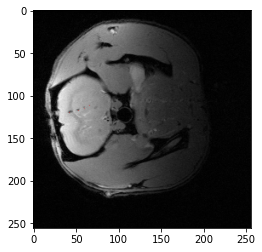

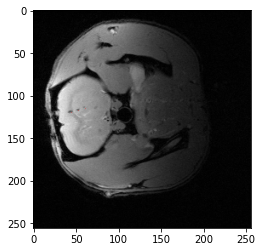

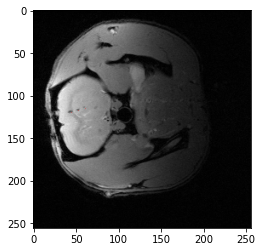

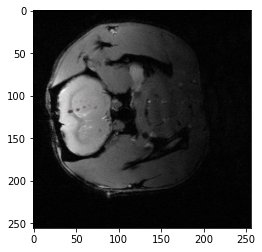

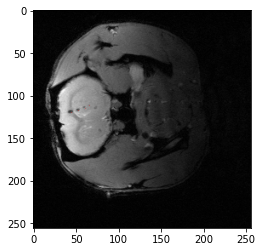

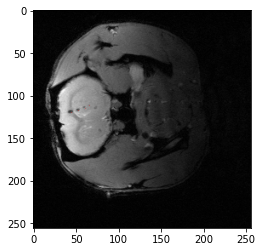

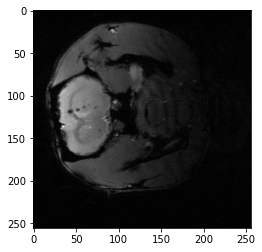

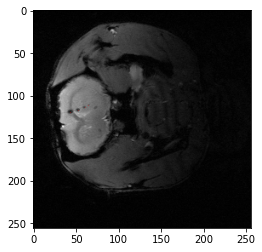

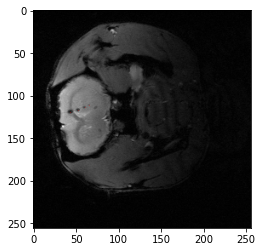

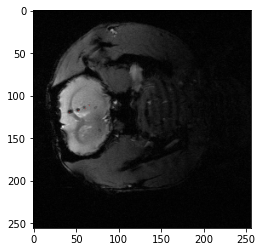

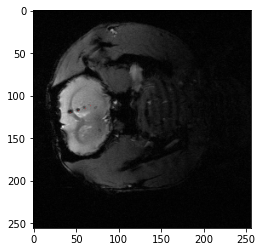

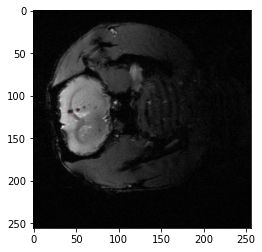

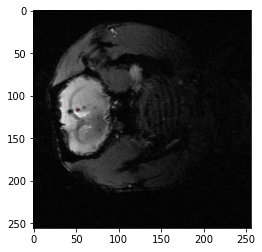

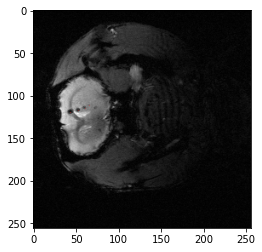

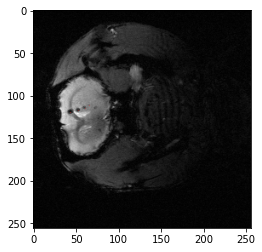

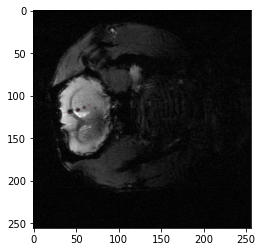

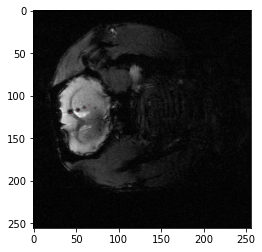

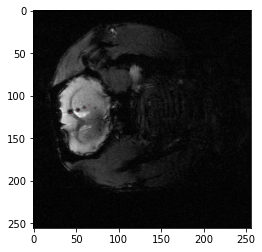

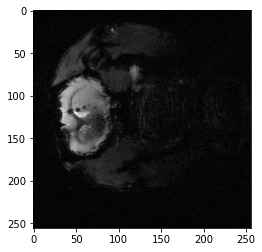

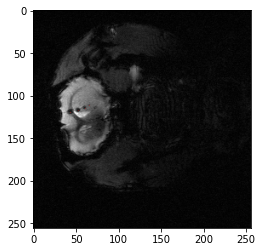

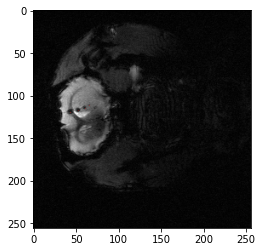

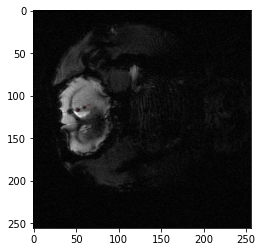

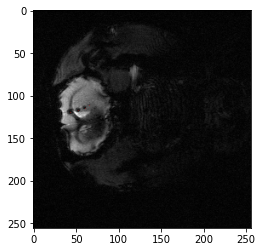

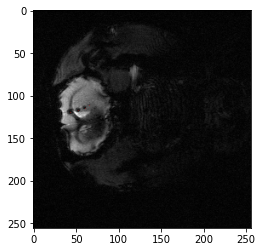

In [52]:
plot_centers(coronal2[:,:,img_slice,:], 8, minimas, avgCenters, weightedCenters)

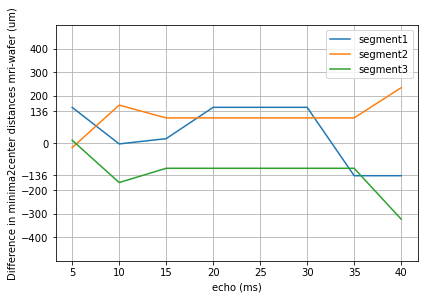

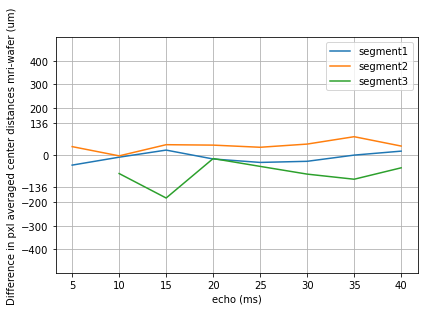

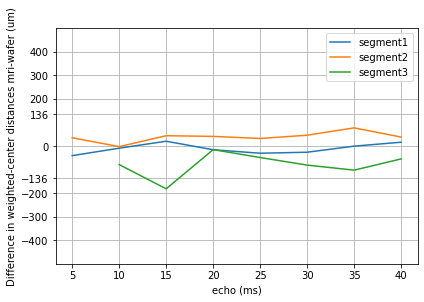

In [62]:
# q4:300 um
# q4-q3 600 um
# q3: 300 um
# q3-q2 755 um
# q2: 300 um
# q2-q1 750 um
# q1: 670 um

# wafer-level center2center distances of each pattern
c2c_dist = [((670/2)+750+(300/2)), ((300/2)+755+(300/2)), ((300/2)+600+(300/2))]

# dist(X[i,:], X[j,:]) = dists[m * i + j - ((i + 2) * (i + 1)) // 2], X: m-by-n
distIdx=[0,3,5]
distsEchos=np.empty((len(distIdx),num_echos))
avgDistsEchos=np.empty_like(distsEchos)
weightedDistsEchos=np.empty_like(distsEchos)
for echo in range(num_echos):
    dists=spatial.distance.pdist(minimas[:,echo,:], metric="euclidean")
    dists2=spatial.distance.pdist(avgCenters[:,echo,:], metric="euclidean")
    dists3=spatial.distance.pdist(weightedCenters[:,echo,:], metric="euclidean")
    distsEchos[:,echo]=dists[distIdx]*136
    avgDistsEchos[:,echo]=dists2[distIdx]*136
    weightedDistsEchos[:,echo]=dists3[distIdx]*136
    

## Segment vs echo
x=np.linspace(5,40,8)
plt.figure()
plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[0,:])
plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[1,:])
plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[2,:])
# plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[3,:])
plt.xlabel("echo (ms)")
# plt.xticks([0, 1])
plt.yticks([-400, -300, -200, -136, 0, 136, 200, 300, 400])
plt.ylabel("Difference in minima2center distances mri-wafer (um)")
plt.ylim([-500, 500])
plt.legend(["segment1", "segment2", "segment3"])
plt.grid()
filename="pxlminima-center2center-echos.pdf"
plt.tight_layout()
plt.savefig(save_path+filename, dpi=dpi)


x=np.linspace(5,40,8)
plt.figure()
plt.plot(x,(avgDistsEchos-np.reshape(c2c_dist, (-1,1)))[0,:])
plt.plot(x,(avgDistsEchos-np.reshape(c2c_dist, (-1,1)))[1,:])
plt.plot(x,(avgDistsEchos-np.reshape(c2c_dist, (-1,1)))[2,:])
# plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[3,:])
plt.xlabel("echo (ms)")
# plt.xticks([0, 1])
plt.yticks([-400, -300, -200, -136, 0, 136, 200, 300, 400])
plt.ylabel("Difference in pxl averaged center distances mri-wafer (um)")
plt.ylim([-500, 500])
plt.legend(["segment1", "segment2", "segment3"])
plt.grid()
filename="averaged-center2center-echos.pdf"
plt.tight_layout()
plt.savefig(save_path+filename, dpi=dpi)



x=np.linspace(5,40,8)
plt.figure()
plt.plot(x,(weightedDistsEchos-np.reshape(c2c_dist, (-1,1)))[0,:])
plt.plot(x,(weightedDistsEchos-np.reshape(c2c_dist, (-1,1)))[1,:])
plt.plot(x,(weightedDistsEchos-np.reshape(c2c_dist, (-1,1)))[2,:])
# plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[3,:])
plt.xlabel("echo (ms)")
# plt.xticks([0, 1])
plt.yticks([-400, -300, -200, -136, 0, 136, 200, 300, 400])
plt.ylabel("Difference in weighted-center distances mri-wafer (um)")
plt.ylim([-500, 500])
plt.legend(["segment1", "segment2", "segment3"])
plt.grid()
filename="weighted-center2center-echos.pdf"
plt.tight_layout()
plt.savefig(save_path+filename, dpi=dpi)


### Plotting the relaxation of pixels passing the threshold at each echo point

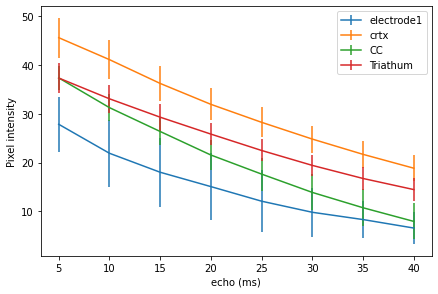

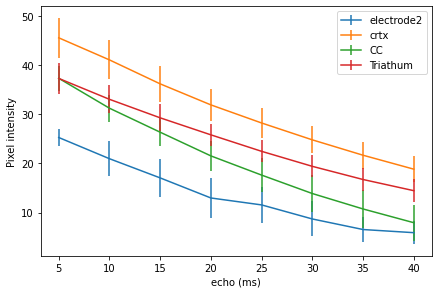

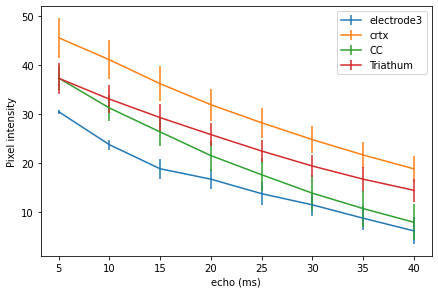

/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/eminhanozil/opt/anaconda3/envs/iacv/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


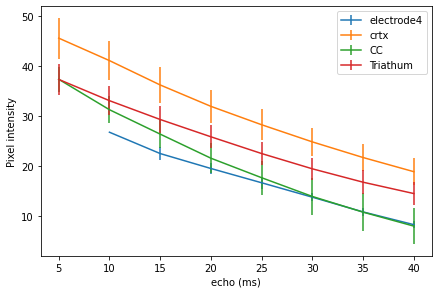

In [49]:
baseName="CC"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_cc=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="crtx"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_crtx=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="deepTissue"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_deep=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

x=np.linspace(5,40,8)
dpi=1000
for j in range(4):
    quad=np.array(segPxIntensities[j])
    quadz=[]
    quadzs=[]
    for i in range(len(px_intensities[j])):
        quadz.append(np.mean(px_intensities[j][i]))
        quadzs.append(np.std(px_intensities[j][i]))
    quadz=np.array(quadz)
    quadzs=np.array(quadzs)

    plt.figure()
    plt.errorbar(x,quadz, yerr=quadzs)
    plt.errorbar(x, np.mean(base_crtx,axis=0), yerr=np.std(base_crtx,axis=0))
    plt.errorbar(x, np.mean(base_cc,axis=0), yerr=np.std(base_cc,axis=0))
    plt.errorbar(x, np.mean(base_deep,axis=0), yerr=np.std(base_deep,axis=0))
    plt.legend(["electrode"+str(j), "crtx", "CC", "Triathum"])
    filename="q"+str(j)"-baselines.pdf"
    plt.tight_layout()
    plt.xlabel("echo (ms)")
    plt.ylabel("Pixel intensity")
    plt.savefig(save_path+filename, dpi=dpi)
    plt.show()

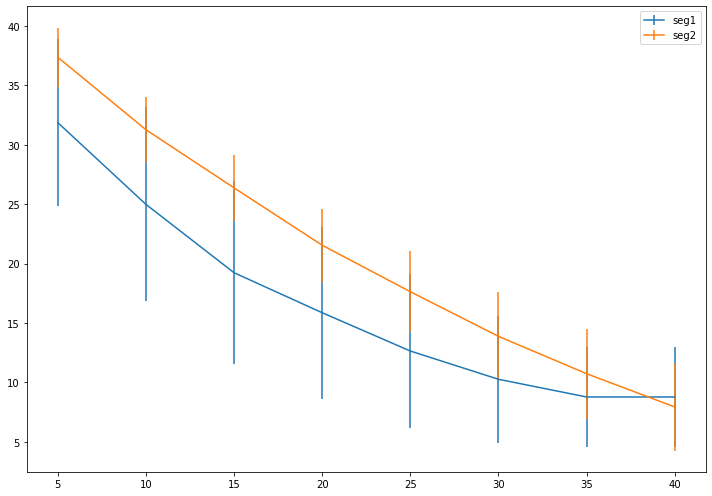

In [274]:
baseName="CC"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_cc=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="crtx"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_crtx=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="deepTissue"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_deep=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   
x=np.linspace(5,40,8)

num_segs=len(seg_areas)
pxIntMeans=np.empty((num_echos,num_segs))
pxIntstd=np.empty((num_echos,num_segs))

for echo in range(num_echos-1):
    img=coronal2[:,:,img_slice,echo]
    for j in range(num_segs):
        pxIntMeans[echo,j]=np.mean(img[masks[j,echo+1,:,:]==1])
        pxIntstd[echo,j]=np.std(img[masks[j,echo+1,:,:]==1])

    for j in range(num_segs):
        pxIntMeans[num_echos-1,j]=np.mean(img[masks[j,num_echos-1,:,:]==1])
        pxIntstd[num_echos-1,j]=np.std(img[masks[j,num_echos-1,:,:]==1])

plt.figure(figsize=(10,7))
plt.errorbar(x, pxIntMeans[:,0], yerr=pxIntstd[:,0])
# plt.errorbar(x, pxIntMeans[:,1], yerr=pxIntstd[:,1])
# plt.errorbar(x, pxIntMeans[:,2], yerr=pxIntstd[:,2])
# plt.errorbar(x, pxIntMeans[:,3], yerr=pxIntstd[:,3])

# plt.errorbar(x, np.mean(base_crtx,axis=0), yerr=np.std(base_crtx,axis=0))
plt.errorbar(x, np.mean(base_cc,axis=0), yerr=np.std(base_cc,axis=0))
# plt.errorbar(x, np.mean(base_deep,axis=0), yerr=np.std(base_deep,axis=0))
plt.legend(["seg1","seg2","seg3","seg4", "cortex", "CC", "Triathum"])
plt.tight_layout()

# rEO_08 Trizone

Segment of interest: tri- sitk-label:0    1
1    2
2    3
Name: Labels, dtype: int64


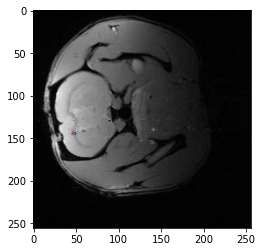

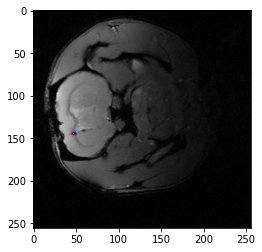

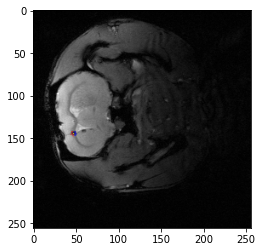

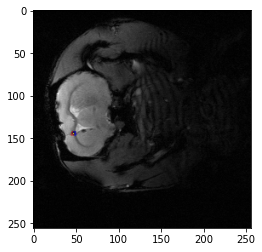

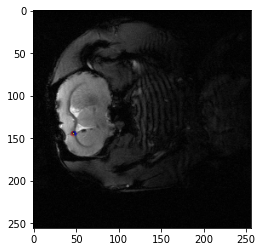

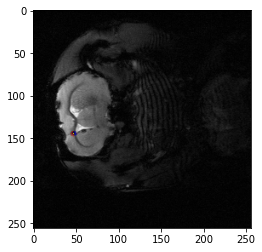

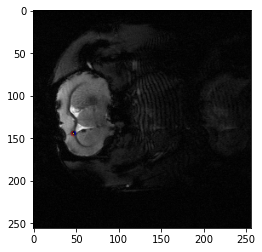

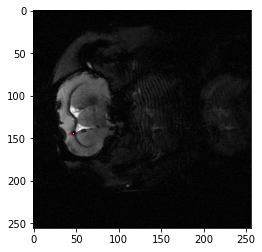

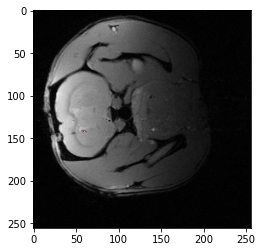

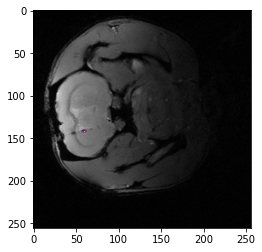

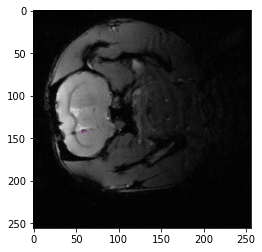

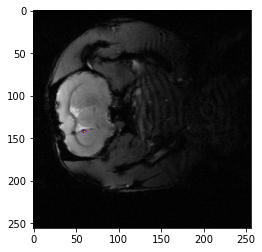

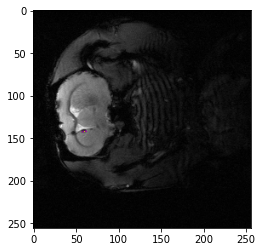

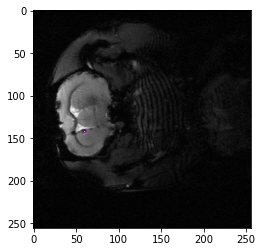

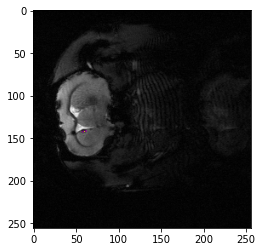

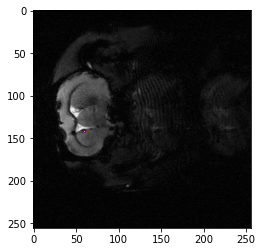

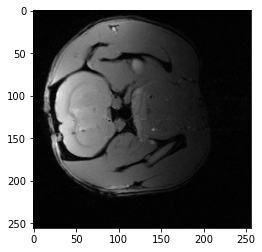

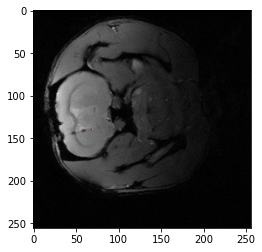

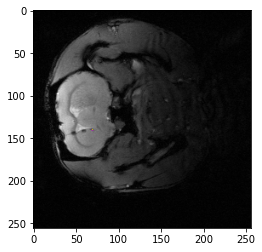

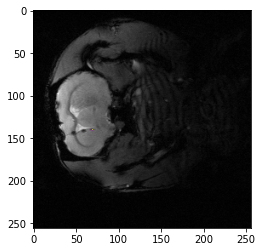

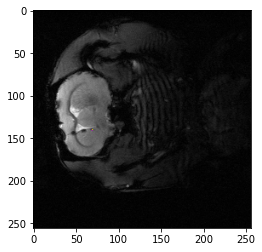

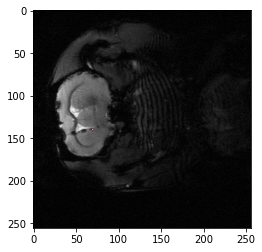

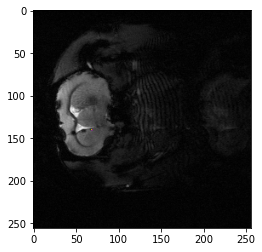

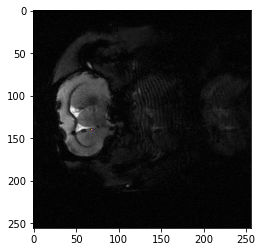

In [34]:
basestruct=["crtx","CC","deepTissue"]
segname="tri-"
img_slice=2
segmentation_mask=coronal2seg[:,:,img_slice]

# seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"]==segname].values
seg_areas=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(segname)]
print("Segment of interest: "+segname+" sitk-label:"+str(seg_areas))
save_path=root+analysed+segname+"-regionspecific/"
dpi=1000
savefigs=False
zthr=-1.95

if not os.path.exists(save_path):
    os.mkdir(save_path)

num_echos=coronal2.shape[-1]
mean_intensities=np.zeros([len(seg_areas),num_echos])

px_count=np.zeros((len(seg_areas),num_echos))
px_intensities=[]
ind=[]

minimas=np.empty((len(seg_areas), num_echos, 2))
avgCenters=np.empty((len(seg_areas), num_echos, 2))
weightedCenters=np.empty((len(seg_areas), num_echos, 2))
segPxIntensities=[]
masks=np.zeros((len(seg_areas), num_echos, segmentation_mask.shape[0],segmentation_mask.shape[1]))

for j,seg in enumerate(seg_areas):
    tmpvals=[]
    segEchoVals=[]
    
    for echo in range(num_echos):
        echovals=[]
        crtxidx=[]
        hpcidx=[]
        thlmsidx=[]
        ccidx=[]
        indx=[]
        indy=[]
        xind_w=[]
        xind_coef=[]
        yind_w=[] 
        yind_coef=[]
        pxcnt=0
        img=coronal2[:,:,img_slice,echo]
        
        minimaTmp=999
        minimIdx=[0,0]
        
        segEchoVals.append(img[segmentation_mask==seg])
        for index in np.array(list(zip(*np.where(segmentation_mask==seg)))):
            base_seg,struct,_,_=get_neigh_basestruct(index, basestruct, labelsdf, segmentation_mask)
            baseline=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)        
            imgz=img_zscore(img[index[0],index[1]],baseline,echo)
            minimaTmp, minimIdx = minima_pixel(img, index, minimaTmp, minimIdx)
                
            if imgz<zthr:
                indx.append(index[1])
                indy.append(index[0])
                xind_w, xind_coef, yind_w, yind_coef= weighted_pixel_index(img, index, xind_w, xind_coef, yind_w, yind_coef)

                if struct==basestruct[0]:
                    crtxidx.append(index)
                elif struct ==basestruct[1]:
                    ccidx.append(index)
                elif struct==basestruct[2]:
                    hpcidx.append(index)
#                 elif struct==basestruct[3]:
#                     thlmsidx.append(index)
                pxcnt=pxcnt+1
                echovals.append(img[index[0],index[1]])
                masks[j,echo,index[0],index[1]]=1
        
        weightedCenters[j,echo,0]=np.sum(xind_w)/np.sum(xind_coef)
        weightedCenters[j,echo,1]=np.sum(yind_w)/np.sum(yind_coef)
        avgCenters[j,echo,0]=np.mean(indx)
        avgCenters[j,echo,1]=np.mean(indy)
        minimas[j,echo,:]=minimIdx
        crtxidx=np.array(crtxidx)
        ccidx=np.array(ccidx)
        hpcidx=np.array(hpcidx)
        thlmsidx=np.array(thlmsidx)

        px_count[j, echo]=pxcnt
        mean_intensities[j,echo]=np.mean(echovals)
        tmpvals.append(echovals)
        plt.imshow(img, cmap='gray')
        
        if crtxidx.any():
            plt.scatter(crtxidx[:,1], crtxidx[:,0], c='r', s=0.01)
        if ccidx.any():
            plt.scatter(ccidx[:,1], ccidx[:,0], c='b', s=0.01)
        if hpcidx.any():
            plt.scatter(hpcidx[:,1], hpcidx[:,0], c='m', s=0.01)
        if thlmsidx.any():
            plt.scatter(thlmsidx[:,1], thlmsidx[:,0], c='g', s=0.01)
        plt.scatter(avgCenters[j,echo,0], avgCenters[j,echo,1], c='y', marker='*', s=0.01)
        if savefigs:
            filename=segname+str(j)+"echo"+str(echo)+".png"
            plt.savefig(save_path+filename, dpi=dpi)
        plt.show()
        
    segPxIntensities.append(segEchoVals)    
    px_intensities.append(tmpvals)

In [35]:
baseName="CC"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_cc=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="crtx"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_crtx=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="deepTissue"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_deep=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   


In [36]:
segment_areas=np.flip([554, 2616, 5254])
segment_lengths=np.array([500, 493, 547])
segment_densities=segment_areas/segment_lengths
print(segment_densities)

[10.508       5.30628803  1.01279707]


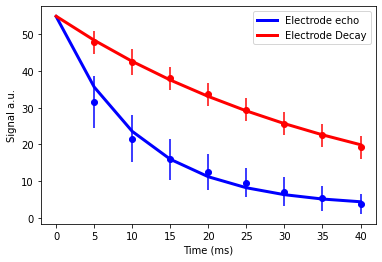

Pattern 0
t2star tissue: 25.3823724833406
t2star electrode: 92.89564846572837
difference: 67.51327598238777


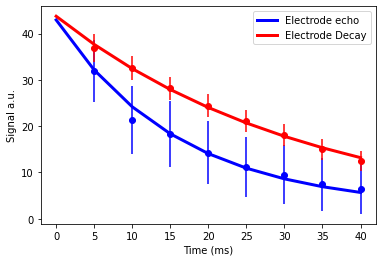

Pattern 2
t2star tissue: 29.952137839436975
t2star electrode: 61.836573991976955
difference: 31.88443615253998


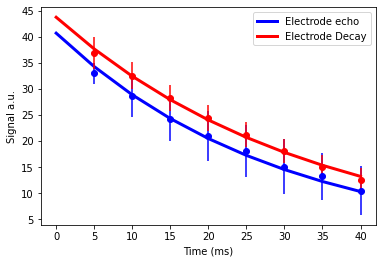

Pattern 3
t2star tissue: 29.952137839436975
t2star electrode: 34.362240552302126
difference: 4.41010271286515


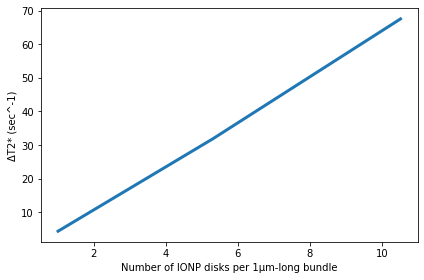

In [37]:
t2diff=[]
t2sigmas=[]

segment_lengths=np.array([500, 493, 547])

elecSegment=0
r=int(np.round(segment_lengths/136/2)[elecSegment])
paramsBase, paramsData, p_sigma_base, p_sigma_data=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int),elecSegment, base_crtx, r=r, savepath=save_path)
print("Pattern 0")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
dt2=1000/paramsData[1]-1000/paramsBase[1]
print("difference: "+str(dt2))
s_combined=np.sqrt(p_sigma_base[1]**2 + p_sigma_data[1]**2)
t2sigmas.append((1000*s_combined)/(dt2*(dt2-s_combined)))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])



elecSegment=1
r=int(np.round(segment_lengths/136/2)[elecSegment])
paramsBase, paramsData, p_sigma_base, p_sigma_data=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int),elecSegment, base_deep,r=r, savepath=save_path)
print("Pattern 2")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
dt2=1000/paramsData[1]-1000/paramsBase[1]
print("difference: "+str(dt2))
s_combined=np.sqrt(p_sigma_base[1]**2 + p_sigma_data[1]**2)
t2sigmas.append((1000*s_combined)/(dt2*(dt2-s_combined)))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])


elecSegment=2
r=int(np.round(segment_lengths/136/2)[elecSegment])

paramsBase, paramsData, p_sigma_base, p_sigma_data=relaxation_fixedROI(coronal2[:,:,img_slice,:], (np.round(np.flip(weightedCenters[elecSegment,-1,:]))).astype(int), elecSegment, base_deep,r=r, savepath=save_path)
print("Pattern 3")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
dt2=1000/paramsData[1]-1000/paramsBase[1]
print("difference: "+str(dt2))
s_combined=np.sqrt(p_sigma_base[1]**2 + p_sigma_data[1]**2)
t2sigmas.append((1000*s_combined)/(dt2*(dt2-s_combined)))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])

t2diffTrio=t2diff
segment_densities_trio=segment_densities
plt.figure()
# plt.errorbar(segment_densities, t2diff, yerr=t2sigmas, linewidth=3)
plt.plot(segment_densities, t2diff, linewidth=3)
plt.ylabel("ΔT2* (sec^-1)")
plt.xlabel("Number of IONP disks per 1µm-long bundle")
plt.tight_layout()
plt.savefig(save_path+"relaxation_vs_density.pdf")



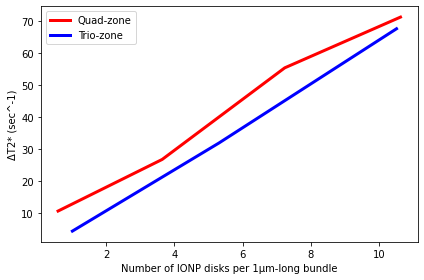

In [39]:
plt.figure()
# plt.errorbar(segment_densities, t2diff, yerr=t2sigmas, linewidth=3)
plt.plot(segment_densities_quad, t2diffQuad, linewidth=3, c='r')
plt.plot(segment_densities_trio, t2diffTrio, linewidth=3, c='b')
plt.legend(["Quad-zone", "Trio-zone"])
plt.ylabel("ΔT2* (sec^-1)")
plt.xlabel("Number of IONP disks per 1µm-long bundle")
plt.tight_layout()
plt.savefig(save_path+"quad_vs_trio-relaxation_vs_density.pdf")

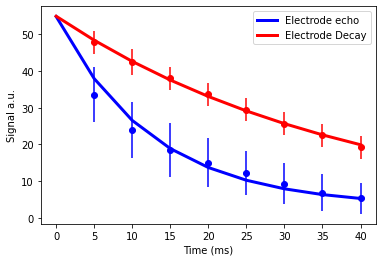

Pattern 0
t2star tissue: 25.379965870291223
t2star electrode: 79.24961822090884
difference: 53.86965235061762
[5.49283582e+01 3.94011562e+01 8.27180613e-25]
[51.76427697 12.61835732  3.08670287]
23.0


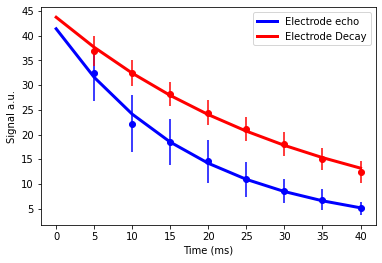

Pattern 2
t2star tissue: 29.952137839436975
t2star electrode: 55.294069930011126
difference: 25.34193209057415
18.0


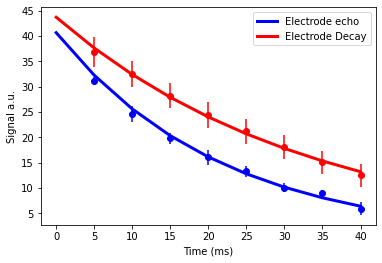

Pattern 3
t2star tissue: 29.952137839436975
t2star electrode: 46.29426250780792
difference: 16.342124668370946
5.0


In [436]:
t2diff=[]

paramsBase, paramsData=relaxation(coronal2[:,:,img_slice,:], 0, base_crtx, masks, savepath=save_path)
print("Pattern 0")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])
print(paramsBase)
print(paramsData)
print(np.sum(masks[0,-1,:,:]))

paramsBase, paramsData=relaxation(coronal2[:,:,img_slice,:], 1, base_deep, masks, savepath=save_path)
print("Pattern 2")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])
print(np.sum(masks[1,-1,:,:]))


paramsBase, paramsData=relaxation(coronal2[:,:,img_slice,:], 2, base_deep, masks, savepath=save_path)
print("Pattern 3")
print("t2star tissue: "+str(1000/paramsBase[1]))
print("t2star electrode: "+str(1000/paramsData[1]))
print("difference: "+str(1000/paramsData[1]-1000/paramsBase[1]))
t2diff.append(1000/paramsData[1]-1000/paramsBase[1])
print(np.sum(masks[2,-1,:,:]))


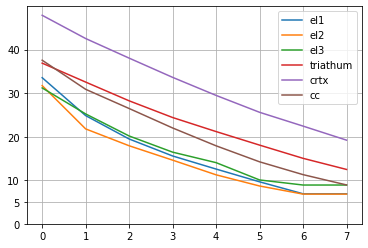

In [251]:
x=np.linspace(5,35,7)
# def relaxation(segments, num_echos, masks, data, img_slice):
num_segs=len(seg_areas)
pxIntMeans=np.empty((num_echos,num_segs))
pxIntstd=np.empty((num_echos,num_segs))

for echo in range(num_echos-1):
    img=coronal2[:,:,img_slice,echo]
    for j in range(num_segs):
        pxIntMeans[echo,j]=np.mean(img[masks[j,echo+1,:,:]==1])
        pxIntstd[echo,j]=np.std(img[masks[j,echo+1,:,:]==1])

    for j in range(num_segs):
        pxIntMeans[num_echos-1,j]=np.mean(img[masks[j,num_echos-1,:,:]==1])
        pxIntstd[num_echos-1,j]=np.std(img[masks[j,num_echos-1,:,:]==1])

plt.plot(pxIntMeans)
plt.plot(np.mean(base_deep, axis=0))
plt.plot(np.mean(base_crtx, axis=0))
plt.plot(np.mean(base_cc, axis=0))
plt.yticks([0,5,10,20,30,40])
plt.grid()
plt.legend(["el1","el2","el3","triathum","crtx","cc",])

[719.34451148 421.50540467 161.9756044 ]
[981.86662122 718.88479273 289.21748467]
[849.71157751 690.36343595 289.39674886]
[981.90212652 555.68522438 288.92422739]
[849.57850277 690.60017085 289.25171436]
[718.8403099  718.95341184 421.48400513]
[718.81077471 555.66348289 289.21049342]
[690.18497093 555.47809277 289.22979857]


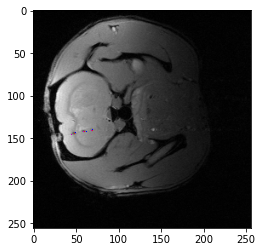

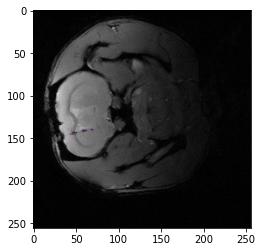

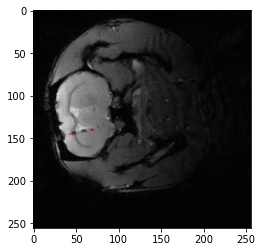

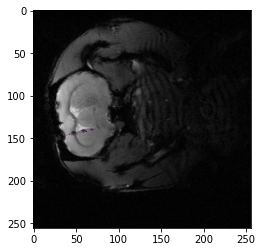

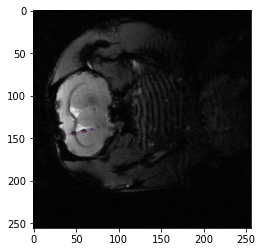

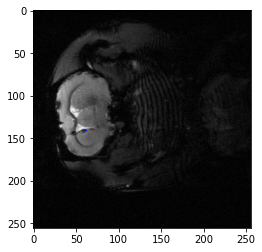

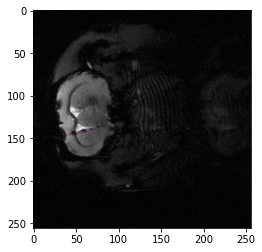

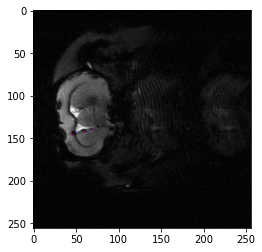

In [212]:
pattern_lengths=np.empty((num_echos, 3))
for echo in range(0,num_echos):
    farp, closep = get_endpoints(seg_areas, weightedCenters, masks, save_path, False)
    pattern_lengths[echo,:]=np.linalg.norm(farp-closep, axis=1)*136
    print(np.linalg.norm(farp-closep, axis=1)*136)
    

plt.plot(segment_densities,np.mean(pattern_lengths, axis=0))
plt.figure()
plt.plot(segment_densities,np.mean(px_count, axis=1))

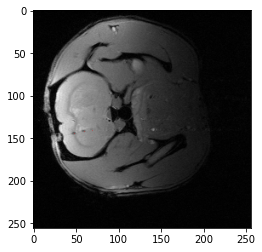

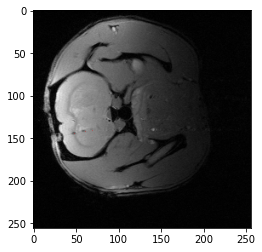

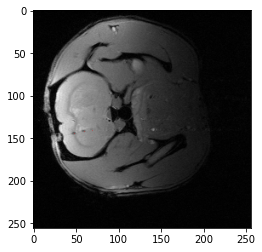

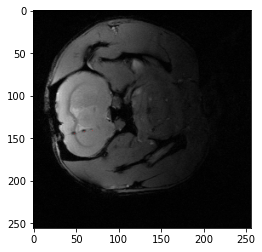

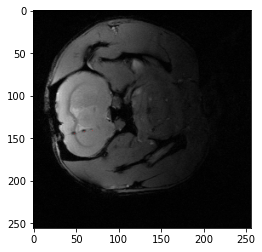

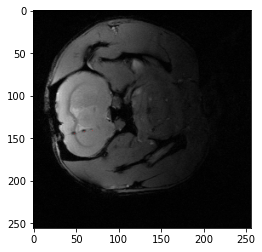

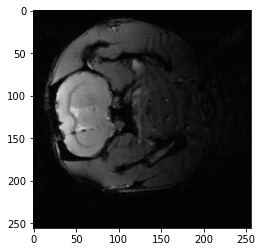

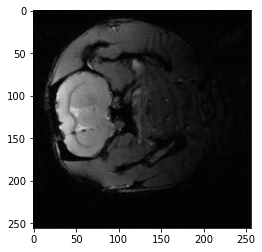

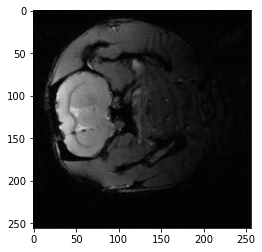

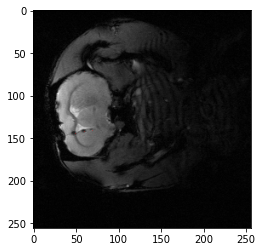

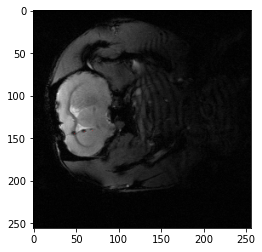

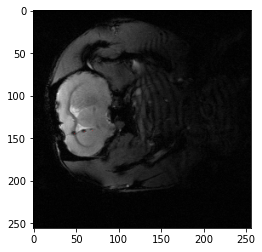

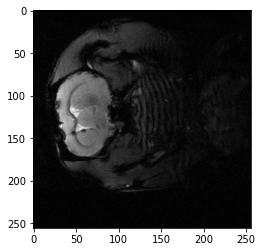

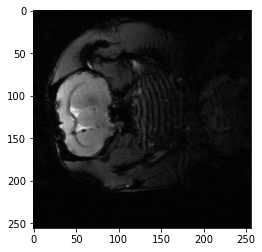

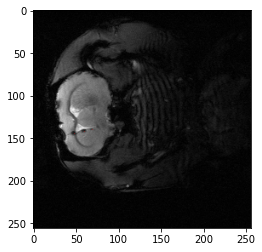

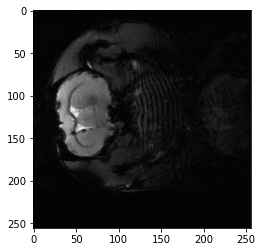

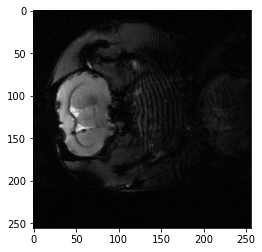

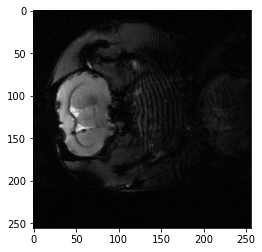

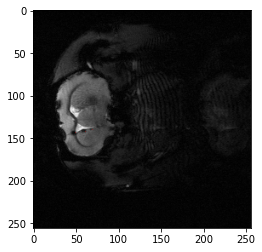

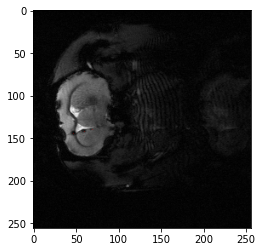

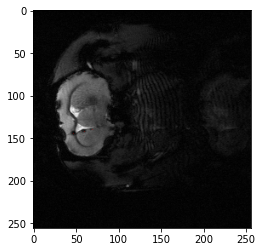

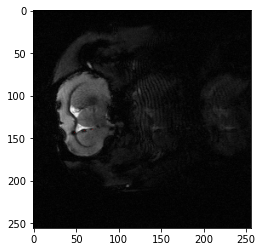

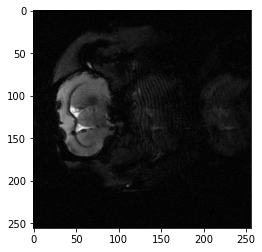

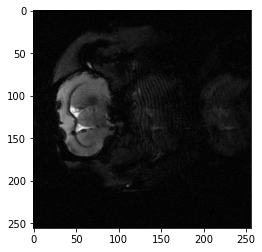

In [41]:
plot_centers(coronal2[:,:,img_slice,:], 8, minimas, avgCenters, weightedCenters)

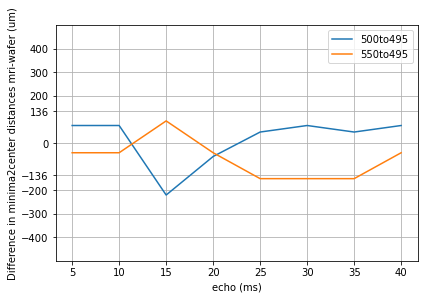

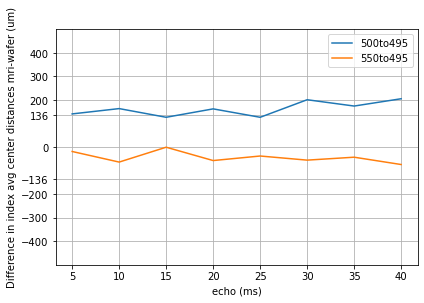

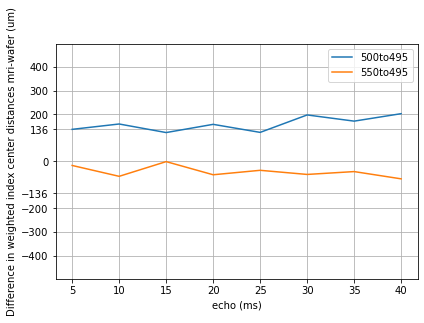

In [72]:
t3=550
t3t2=750 
t2=495
t2t1=1110
t1=500 
m=3

i=0
j=1
id0=m * i + j - ((i + 2) * (i + 1)) // 2
i=1
j=2
id1=m * i + j - ((i + 2) * (i + 1)) // 2
# wafer-level center2center distances of each pattern
c2c_dist = [((t2/2)+t2t1+(t1/2)), ((t3/2)+t3t2+(t2/2))]

# dist(X[i,:], X[j,:]) = dists[m * i + j - ((i + 2) * (i + 1)) // 2], X: m-by-n
distIdx=[id0,id1]
distsEchos=np.empty((len(distIdx),num_echos))
avgDistsEchos=np.empty_like(distsEchos)
weightedDistsEchos=np.empty_like(distsEchos)
for echo in range(num_echos):
    dists=spatial.distance.pdist(minimas[:,echo,:], metric="euclidean")
    dists2=spatial.distance.pdist(avgCenters[:,echo,:], metric="euclidean")
    dists3=spatial.distance.pdist(weightedCenters[:,echo,:], metric="euclidean")
    distsEchos[:,echo]=dists[distIdx]*136
    avgDistsEchos[:,echo]=dists2[distIdx]*136
    weightedDistsEchos[:,echo]=dists3[distIdx]*136
    

## Segment vs echo
x=np.linspace(5,40,8)
plt.figure()
plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[0,:])
plt.plot(x,(distsEchos-np.reshape(c2c_dist, (-1,1)))[1,:])
plt.xlabel("echo (ms)")
# plt.xticks([0, 1])
plt.yticks([-400, -300, -200, -136, 0, 136, 200, 300, 400])
plt.ylabel("Difference in minima2center distances mri-wafer (um)")
plt.ylim([-500, 500])
plt.legend([str(t1)+"to"+str(t2), str(t3)+"to"+str(t2)])
plt.grid()
filename="minima-center2center-echos.pdf"
plt.tight_layout()
plt.savefig(save_path+filename, dpi=dpi)

plt.figure()
plt.plot(x,(avgDistsEchos-np.reshape(c2c_dist, (-1,1)))[0,:])
plt.plot(x,(avgDistsEchos-np.reshape(c2c_dist, (-1,1)))[1,:])
plt.xlabel("echo (ms)")
# plt.xticks([0, 1])
plt.yticks([-400, -300, -200, -136, 0, 136, 200, 300, 400])
plt.ylabel("Difference in index avg center distances mri-wafer (um)")
plt.ylim([-500, 500])
plt.legend([str(t1)+"to"+str(t2), str(t3)+"to"+str(t2)])
plt.grid()
filename="avgindex-center2center-echos.pdf"
plt.tight_layout()
plt.savefig(save_path+filename, dpi=dpi)

plt.figure()
plt.plot(x,(weightedDistsEchos-np.reshape(c2c_dist, (-1,1)))[0,:])
plt.plot(x,(weightedDistsEchos-np.reshape(c2c_dist, (-1,1)))[1,:])
plt.xlabel("echo (ms)")
# plt.xticks([0, 1])
plt.yticks([-400, -300, -200, -136, 0, 136, 200, 300, 400])
plt.ylabel("Difference in weighted index center distances mri-wafer (um)")
plt.ylim([-500, 500])
plt.legend([str(t1)+"to"+str(t2), str(t3)+"to"+str(t2)])
plt.grid()
filename="weightedindex-center2center-echos.pdf"
plt.tight_layout()
plt.savefig(save_path+filename, dpi=dpi)



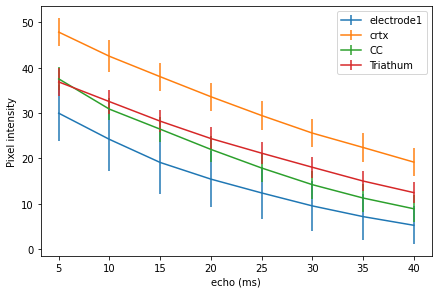

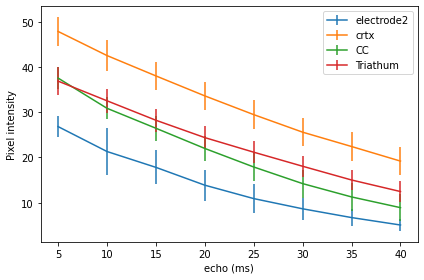

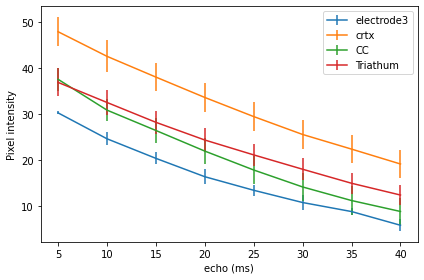

In [44]:
baseName="CC"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_cc=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="crtx"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_crtx=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   

baseName="deepTissue"
base_seg=labelsdf["Labels"][labelsdf["Anatomical Regions"].str.contains(baseName)].values[0]
base_deep=get_baseline_vals(img_slice, base_seg, coronal2seg, coronal2)   


x=np.linspace(5,40,8)
dpi=1000

for j in range(3):
    pxVals=np.array(segPxIntensities[j])
    pxVals_z_mean=[]
    pxVals_z_std=[]
    for i in range(len(px_intensities[j])):
        pxVals_z_mean.append(np.mean(px_intensities[j][i]))
        pxVals_z_std.append(np.std(px_intensities[j][i]))
    pxVals_z_mean=np.array(pxVals_z_mean)
    pxVals_z_std=np.array(pxVals_z_std)

    plt.figure()
    plt.errorbar(x,pxVals_z_mean, yerr=pxVals_z_std)
    plt.errorbar(x, np.mean(base_crtx,axis=0), yerr=np.std(base_crtx,axis=0))
    plt.errorbar(x, np.mean(base_cc,axis=0), yerr=np.std(base_cc,axis=0))
    plt.errorbar(x, np.mean(base_deep,axis=0), yerr=np.std(base_deep,axis=0))
    plt.legend(["electrode"+str(j), "crtx", "CC", "Triathum"])
    filename="tri"+str(j)+"-baselines.pdf"
    plt.tight_layout()
    plt.xlabel("echo (ms)")
    plt.ylabel("Pixel intensity")
    plt.savefig(save_path+filename, dpi=dpi)
    plt.show()


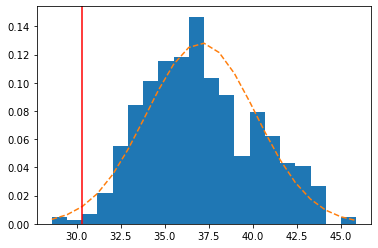

In [438]:
path="/Users/eminhanozil/Dropbox (Yanik Lab)/Localization Manuscript 2024/RAT DATA/rEO_08/mri-analysed/"

mu=np.mean(baseline[:,0])
sigma=np.std(baseline[:,0])
num_bins = 20
x=baseline[:,0]

fig, ax = plt.subplots()
n, bins, patches = ax.hist(x, num_bins, density=True)
# plt.hist(baseline[:,0], bins=num_bins)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
vlin=bins[bins<mu-2*sigma][-1]
plt.axvline(x = vlin, color = 'r', label = 'axvline - full height')
filename="sample_baseline.pdf"
plt.savefig(path+filename, dpi=1000)